In [1]:
pip install opendatasets

In [2]:
#Dataset preparation
#User Name: chizitaraigwe
#Authentication key: 4b1a9ab784421ff19944bd8de86ae9b3

import opendatasets as opd
import pandas as pd

In [3]:
opd.download("https://www.kaggle.com/datasets/volkandl/car-brand-logos")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: s
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/volkandl/car-brand-logos


100%|██████████| 217M/217M [00:02<00:00, 92.0MB/s]


In [4]:
opd.download("https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: s
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition


100%|██████████| 159M/159M [00:02<00:00, 77.4MB/s]


In [5]:
opd.download("https://www.kaggle.com/datasets/kshitij192/cars-image-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: s
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kshitij192/cars-image-dataset


100%|██████████| 36.3M/36.3M [00:00<00:00, 54.4MB/s]

In [6]:
# #Data of Toyota cars
# opd.download("https://www.kaggle.com/datasets/occultainsights/toyota-cars-over-20k-labeled-images")

In [7]:
# opd.download("https://www.kaggle.com/datasets/occultainsights/bmw-cars-over-11k-labeled-images")

In [8]:
import os
os.chdir('/content')
print(os.getcwd())

/content


In [9]:
#Now to retrieve the dataset and collect the information
import torch
from PIL import Image
import torch.utils.data as data
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
class Place2_Data(data.Dataset):
    def __init__(self, root, transforms=None):
        # location of the dataset
        self.root = root
        # list of classes
        self.classes= (os.listdir(self.root))
        self.classes_to_num= {c:i for i,c in enumerate(self.classes)}

        # all images
        self.all_images= [(os.path.join(root, c, img), self.classes_to_num[c]) for c in self.classes for img in os.listdir(os.path.join(root, c))]
        # transforms
        self.transforms = transforms

    def __getitem__(self, index):
      image, classes = self.all_images[index]
      image = Image.open(image).convert(mode="RGB")
      #img = Image.open(img_path).convert('RGB')
      # apply transformation
      if self.transforms:
          image = self.transforms(image)
      # return the image and class
      return image, classes

    def __len__(self):
        # return the total number of images
        return len(self.all_images)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
class ResNet50Multiclass(nn.Module):
    def __init__(self, num_brand_classes, num_type_classes):
        super(ResNet50Multiclass, self).__init__()
        self.model = models.resnet50(pretrained=True)
        # Remove the original fully connected layer
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        in_features = 2048  # Output from resnet50 after the average pooling layer

        # Define two fully connected layers for car brands and car types
        self.fc_brand = nn.Linear(in_features, num_brand_classes)
        self.fc_type = nn.Linear(in_features, num_type_classes)

    def forward(self, x):
        features = self.model(x)
        features = features.view(features.size(0), -1)  # Flatten the features
        brand_output = self.fc_brand(features)
        type_output = self.fc_type(features)
        return brand_output, type_output

In [11]:
# import torchsummary as summary
# resnet = ResNet50Multiclass(num_brand_classes=len(logoTrainData.classes), num_type_classes=len(carData.classes))
# resnet.to(device)
# summary.summary(resnet,input_size=(3,224,224))

In [12]:
#Define the dataset for the car logos
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomAffine, RandomRotation
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
carImageData = "/content/vehicle-type-recognition/Dataset"
carTrainLogoData = "/content/car-brand-logos/Car_Brand_Logos/Train"
carTestLogoData = "/content/car-brand-logos/Car_Brand_Logos/Test"

In [14]:
# Create datasets
logoTrainData = Place2_Data(carTrainLogoData, transforms=image_transform)
logoTest = Place2_Data(carTestLogoData, transforms=image_transform)
carData = Place2_Data(carImageData, transforms=image_transform)

In [15]:
# Split datasets into training, validation, and test sets
train_size = int(0.8 * len(carData))
test_val_size = len(carData) - train_size
train_data, test_val_data = random_split(carData, [train_size, test_val_size])

val_size = int(0.5 * len(test_val_data))
test_size = len(test_val_data) - val_size
val_data, test_data = random_split(test_val_data, [val_size, test_size])

In [16]:
# Create data loaders for both models
train_loader_type = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader_type = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader_type = DataLoader(test_data, batch_size=32, shuffle=False)

train_loader_logo = DataLoader(logoTrainData, batch_size=32, shuffle=True)
test_loader_logo = DataLoader(logoTest, batch_size=32, shuffle=False)

In [17]:
len(carData.all_images)

400

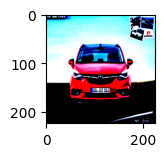

In [18]:
# import plot library
import matplotlib.pyplot as plt
# iterate the dataloader
_, (example_datas, labels) = next(enumerate(train_loader_logo))
# get the first data
sample = example_datas[1]
plt.subplot(3, 3, 1)
plt.imshow(sample.permute(1, 2, 0))


In [19]:
# Define the multiclass model
model_A = ResNet50Multiclass(num_brand_classes=len(logoTest.classes), num_type_classes=len(carData.classes))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_A = model_A.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


In [20]:
model_B = ResNet50Multiclass(num_brand_classes=len(logoTrainData.classes), num_type_classes=len(carData.classes))
model_B = model_B.to(device)

In [21]:
# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_A = optim.Adam(model_A.parameters(), lr=0.0002)
optimizer_B = optim.Adam(model_B.parameters(), lr=0.0002)


In [22]:
# Training loop for Model A (focus on car brands)
num_epochs = 20
for epoch in range(num_epochs):
    model_A.train()
    running_loss_A = 0.0

    for images_brand, labels_brand in train_loader_logo:
        images_brand, labels_brand = images_brand.to(device), labels_brand.to(device)

        optimizer_A.zero_grad()

        # Forward pass for Model A
        brand_output_A, _ = model_A(images_brand)

        # Calculate loss for Model A
        loss_brand_A = criterion(brand_output_A, labels_brand)

        loss_brand_A.backward()
        optimizer_A.step()

        running_loss_A += loss_brand_A.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss Model A: {running_loss_A/len(train_loader_logo)}")

Epoch 1/20 - Loss Model A: 0.5411279911670503
Epoch 2/20 - Loss Model A: 0.22958336386216593
Epoch 3/20 - Loss Model A: 0.1396992389772889
Epoch 4/20 - Loss Model A: 0.13672796090994077
Epoch 5/20 - Loss Model A: 0.10528416152383331
Epoch 6/20 - Loss Model A: 0.0777480154286457
Epoch 7/20 - Loss Model A: 0.083242902698738
Epoch 8/20 - Loss Model A: 0.04190052135205014
Epoch 9/20 - Loss Model A: 0.11674803831243204
Epoch 10/20 - Loss Model A: 0.04127173554122778
Epoch 11/20 - Loss Model A: 0.01773729246504652
Epoch 12/20 - Loss Model A: 0.019085976241386342
Epoch 13/20 - Loss Model A: 0.018060276931729402
Epoch 14/20 - Loss Model A: 0.015497194920648832
Epoch 15/20 - Loss Model A: 0.01183372186909465
Epoch 16/20 - Loss Model A: 0.008651996234025147
Epoch 17/20 - Loss Model A: 0.01881182526939702
Epoch 18/20 - Loss Model A: 0.029408022519304192
Epoch 19/20 - Loss Model A: 0.08727893292538444
Epoch 20/20 - Loss Model A: 0.10043708230899293


In [23]:
# Training loop for Model B (focus on car types)
for epoch in range(num_epochs):
    model_B.train()
    running_loss_B = 0.0

    for images_type, labels_type in train_loader_type:
        images_type, labels_type = images_type.to(device), labels_type.to(device)

        optimizer_B.zero_grad()

        # Forward pass for Model B
        _, type_output_B = model_B(images_type)

        # Calculate loss for Model B
        loss_type_B = criterion(type_output_B, labels_type)

        loss_type_B.backward()
        optimizer_B.step()

        running_loss_B += loss_type_B.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss Model B: {running_loss_B/len(train_loader_type)}")


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20 - Loss Model B: 0.5209751173853874
Epoch 2/20 - Loss Model B: 0.09701013136655093
Epoch 3/20 - Loss Model B: 0.04764175214804709
Epoch 4/20 - Loss Model B: 0.03984006460523233
Epoch 5/20 - Loss Model B: 0.01318682029377669
Epoch 6/20 - Loss Model B: 0.028398978372570126
Epoch 7/20 - Loss Model B: 0.00817385276313871
Epoch 8/20 - Loss Model B: 0.014136527443770319
Epoch 9/20 - Loss Model B: 0.0014407838374609129
Epoch 10/20 - Loss Model B: 0.001523553443257697
Epoch 11/20 - Loss Model B: 0.0023249295802088453
Epoch 12/20 - Loss Model B: 0.0019244461902417243
Epoch 13/20 - Loss Model B: 0.0010162173333810643
Epoch 14/20 - Loss Model B: 0.10967753491713665
Epoch 15/20 - Loss Model B: 0.1390762772411108
Epoch 16/20 - Loss Model B: 0.07667491752654314
Epoch 17/20 - Loss Model B: 0.03450892218388617
Epoch 18/20 - Loss Model B: 0.021188357938081027
Epoch 19/20 - Loss Model B: 0.012174641236197204
Epoch 20/20 - Loss Model B: 0.02627146309823729


In [24]:
# Evaluation function
def test_model(model, test_loader, device, task='type'):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)[0] if task == 'brand' else model(inputs)[1]
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy ({task}): {accuracy:.2f}%')

In [25]:

print("\nTesting Model A (car brands focus)...")
test_model(model_A, test_loader_logo, device, task='brand')  # Test Model A on car brands
test_model(model_A, test_loader_type, device, task='type')  # Test Model A on car types



Testing Model A (car brands focus)...
Test Accuracy (brand): 87.00%
Test Accuracy (type): 20.00%


In [26]:

print("\nTesting Model B (car types focus)...")
test_model(model_B, test_loader_logo, device, task='brand')  # Test Model B on car brands
test_model(model_B, test_loader_type, device, task='type')  # Test Model B on car types


Testing Model B (car types focus)...
Test Accuracy (brand): 9.00%
Test Accuracy (type): 85.00%


In [27]:
m_model_A = model_A
f_model_A = model_A
m_model_B = model_B
f_model_B = model_B

In [28]:
#The Mutual Learning Process

In [29]:
# Mutual learning loss function
def mutual_learning_loss(output_A, output_B, target, T=2):
    """
    Calculate the mutual learning loss, which is the Kullback-Leibler divergence between the
    softmax outputs of model_A and model_B.
    T is the temperature parameter for softening the logits.
    """
    soft_A = nn.functional.log_softmax(output_A / T, dim=1)
    soft_B = nn.functional.softmax(output_B / T, dim=1)
    loss = nn.functional.kl_div(soft_A, soft_B, reduction='batchmean') * (T * T)
    return loss

In [30]:
# Training loop with mutual learning
num_epochs = 20
lambda_ = 0.5  # Weight for mutual learning loss

for epoch in range(num_epochs):
    m_model_A.train()

    running_loss_A = 0.0

    # Model A focuses more on car brands, but also learns from car types
    for (images_brand, labels_brand), (images_type, labels_type) in zip(train_loader_logo, train_loader_type):
        images_brand, labels_brand = images_brand.to(device), labels_brand.to(device)
        images_type, labels_type = images_type.to(device), labels_type.to(device)

        optimizer_A.zero_grad()

        # Forward pass for Model A
        brand_output_A, type_output_A = m_model_A(images_brand)
        type_output_A_2 = m_model_A(images_type)[1]  # Get type output for car types data

        # Calculate losses for Model A
        loss_brand_A = criterion(brand_output_A, labels_brand)
        loss_type_A = criterion(type_output_A_2, labels_type)

        with torch.no_grad():
            brand_output_B, type_output_B = model_B(images_type)

        # Mutual learning loss
        mutual_loss_A = -torch.sum(torch.softmax(brand_output_B, dim=1) * torch.log_softmax(brand_output_A, dim=1), dim=1).mean()
        mutual_loss_A += -torch.sum(torch.softmax(type_output_B, dim=1) * torch.log_softmax(type_output_A_2, dim=1), dim=1).mean()

        # Total loss for Model A
        total_loss_A = loss_brand_A + 0.5 * loss_type_A + lambda_ * mutual_loss_A
        total_loss_A.backward()
        optimizer_A.step()

        running_loss_A += total_loss_A.item()


    print(f"Epoch {epoch+1}/{num_epochs} - Loss Model A: {running_loss_A/len(train_loader_type)}")

Epoch 1/20 - Loss Model A: 5.026371264457703
Epoch 2/20 - Loss Model A: 2.91513352394104
Epoch 3/20 - Loss Model A: 2.2428626298904417
Epoch 4/20 - Loss Model A: 2.0343040585517884
Epoch 5/20 - Loss Model A: 1.9160762548446655
Epoch 6/20 - Loss Model A: 1.9003225207328795
Epoch 7/20 - Loss Model A: 1.8379117369651794
Epoch 8/20 - Loss Model A: 1.8443563580513
Epoch 9/20 - Loss Model A: 1.832475483417511
Epoch 10/20 - Loss Model A: 1.8221534848213197
Epoch 11/20 - Loss Model A: 1.8034896016120912
Epoch 12/20 - Loss Model A: 1.7944860339164734
Epoch 13/20 - Loss Model A: 1.796592104434967
Epoch 14/20 - Loss Model A: 1.7946195960044862
Epoch 15/20 - Loss Model A: 1.7858216285705566
Epoch 16/20 - Loss Model A: 1.787221646308899
Epoch 17/20 - Loss Model A: 1.7758725881576538
Epoch 18/20 - Loss Model A: 1.7915038228034974
Epoch 19/20 - Loss Model A: 1.7984546422958374
Epoch 20/20 - Loss Model A: 1.7783400893211365


In [31]:
for epoch in range(num_epochs):
  m_model_B.train()

  running_loss_B = 0.0
  # Model B focuses more on car types, but also learns from car brands
  for (images_type, labels_type), (images_brand, labels_brand) in zip(train_loader_type, train_loader_logo):
      images_type, labels_type = images_type.to(device), labels_type.to(device)
      images_brand, labels_brand = images_brand.to(device), labels_brand.to(device)

      optimizer_B.zero_grad()

      # Forward pass for Model B
      brand_output_B, type_output_B = m_model_B(images_brand)
      type_output_B_2 = m_model_B(images_type)[1]  # Get type output for car types data

      # Calculate losses for Model B
      loss_type_B = criterion(type_output_B_2, labels_type)
      loss_brand_B = criterion(brand_output_B, labels_brand)

      with torch.no_grad():
          brand_output_A, type_output_A = model_A(images_brand)

      # Mutual learning loss
      mutual_loss_B = -torch.sum(torch.softmax(brand_output_A, dim=1) * torch.log_softmax(brand_output_B, dim=1), dim=1).mean()
      mutual_loss_B += -torch.sum(torch.softmax(type_output_A, dim=1) * torch.log_softmax(type_output_B_2, dim=1), dim=1).mean()

      # Total loss for Model B
      total_loss_B = loss_type_B + 0.5 * loss_brand_B + lambda_ * mutual_loss_B
      total_loss_B.backward()
      optimizer_B.step()

      running_loss_B += total_loss_B.item()

  print(f"Epoch {epoch+1}/{num_epochs} - Loss Model B: {running_loss_B/len(train_loader_type)}")

Epoch 1/20 - Loss Model B: 4.6398731708526615
Epoch 2/20 - Loss Model B: 3.3561201095581055
Epoch 3/20 - Loss Model B: 2.7599645137786863
Epoch 4/20 - Loss Model B: 2.5331584930419924
Epoch 5/20 - Loss Model B: 2.3104799032211303
Epoch 6/20 - Loss Model B: 2.3304309129714964
Epoch 7/20 - Loss Model B: 2.2734689712524414
Epoch 8/20 - Loss Model B: 2.2846449613571167
Epoch 9/20 - Loss Model B: 2.233642339706421
Epoch 10/20 - Loss Model B: 2.179830527305603
Epoch 11/20 - Loss Model B: 2.169286918640137
Epoch 12/20 - Loss Model B: 2.1491469621658323
Epoch 13/20 - Loss Model B: 2.192752242088318
Epoch 14/20 - Loss Model B: 2.208958387374878
Epoch 15/20 - Loss Model B: 2.1352848291397093
Epoch 16/20 - Loss Model B: 2.16834819316864
Epoch 17/20 - Loss Model B: 2.132338523864746
Epoch 18/20 - Loss Model B: 2.1471558213233948
Epoch 19/20 - Loss Model B: 2.1208825588226317
Epoch 20/20 - Loss Model B: 2.1240820050239564


In [32]:
# Test the models
test_model(m_model_A, test_loader_logo, device, task='brand')  # Test Model A on car brands
test_model(m_model_A, test_loader_type, device, task='type')  # Test Model A on car types

Test Accuracy (brand): 88.00%
Test Accuracy (type): 70.00%


In [33]:
test_model(m_model_B, test_loader_logo, device, task='brand')  # Test Model B on car brands
test_model(m_model_B, test_loader_type, device, task='type')  # Test Model B on car types

Test Accuracy (brand): 85.00%
Test Accuracy (type): 90.00%


In [34]:
# Feature level Model fusion
class FusionModel(nn.Module):
    def __init__(self, num_brand_classes, num_type_classes):
        super(FusionModel, self).__init__()
        # Assuming the output from both models has the same size, i.e., 2048 for ResNet50
        self.fc_fusion_brand = nn.Linear(2 * num_brand_classes, num_brand_classes)
        self.fc_fusion_type = nn.Linear(2 * num_type_classes, num_type_classes)

    def forward(self, brand_output_A, brand_output_B, type_output_A, type_output_B):
        # Concatenate outputs from Model A and Model B
        fusion_brand = torch.cat((brand_output_A, brand_output_B), dim=1)
        fusion_type = torch.cat((type_output_A, type_output_B), dim=1)

        # Pass through the fully connected layer
        fusion_brand_output = self.fc_fusion_brand(fusion_brand)
        fusion_type_output = self.fc_fusion_type(fusion_type)

        return fusion_brand_output, fusion_type_output

In [35]:
# Instantiate the fusion model
fusion_model = FusionModel(num_brand_classes=len(logoTrainData.classes), num_type_classes=len(carData.classes))
fusion_model = fusion_model.to(device)

# Define optimizer and loss function for the fusion model
optimizer_fusion = optim.Adam(fusion_model.parameters(), lr=0.0001)
criterion_fusion = nn.CrossEntropyLoss()

# Training loop for the fusion model
for epoch in range(num_epochs):
    fusion_model.train()
    running_loss_fusion = 0.0

    # Loop through both datasets
    for (images_brand, labels_brand), (images_type, labels_type) in zip(train_loader_logo, train_loader_type):
        images_brand, labels_brand = images_brand.to(device), labels_brand.to(device)
        images_type, labels_type = images_type.to(device), labels_type.to(device)

        optimizer_fusion.zero_grad()

        # Forward pass through Model A and Model B
        brand_output_A, type_output_A = model_A(images_brand)
        brand_output_B, type_output_B = model_B(images_type)

        # Forward pass through the fusion model
        fusion_brand_output, fusion_type_output = fusion_model(brand_output_A, brand_output_B, type_output_A, type_output_B)

        # Calculate fusion loss
        loss_fusion_brand = criterion_fusion(fusion_brand_output, labels_brand)
        loss_fusion_type = criterion_fusion(fusion_type_output, labels_type)

        total_loss_fusion = loss_fusion_brand + loss_fusion_type

        total_loss_fusion.backward()
        optimizer_fusion.step()

        running_loss_fusion += total_loss_fusion.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Fusion Model Loss: {running_loss_fusion/len(train_loader_logo)+len(train_loader_type)}")



Epoch 1/20 - Fusion Model Loss: 10.47740428960776
Epoch 2/20 - Fusion Model Loss: 10.48310658599757
Epoch 3/20 - Fusion Model Loss: 10.480366613291487
Epoch 4/20 - Fusion Model Loss: 10.48455049418196
Epoch 5/20 - Fusion Model Loss: 10.464703846581374
Epoch 6/20 - Fusion Model Loss: 10.470106734505183
Epoch 7/20 - Fusion Model Loss: 10.476882925516442
Epoch 8/20 - Fusion Model Loss: 10.480089996434465
Epoch 9/20 - Fusion Model Loss: 10.469051883190494
Epoch 10/20 - Fusion Model Loss: 10.468345614928234
Epoch 11/20 - Fusion Model Loss: 10.464137164852287
Epoch 12/20 - Fusion Model Loss: 10.4691123358811
Epoch 13/20 - Fusion Model Loss: 10.465304145330116
Epoch 14/20 - Fusion Model Loss: 10.457782283613954
Epoch 15/20 - Fusion Model Loss: 10.463456479808952
Epoch 16/20 - Fusion Model Loss: 10.46818857555148
Epoch 17/20 - Fusion Model Loss: 10.454742268670964
Epoch 18/20 - Fusion Model Loss: 10.459467414059217
Epoch 19/20 - Fusion Model Loss: 10.452131893061384
Epoch 20/20 - Fusion Model 

In [36]:
def test_fusion_model(model_A, model_B, fusion_model, test_loader, device, task='brand'):
    model_A.eval()
    model_B.eval()
    fusion_model.eval()
    model_A.to(device)
    model_B.to(device)
    fusion_model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get outputs from both Model A and Model B
            brand_output_A, type_output_A = model_A(inputs)
            brand_output_B, type_output_B = model_B(inputs)

            # Get the fusion model's output
            if task == 'brand':
                outputs = fusion_model(brand_output_A, brand_output_B, type_output_A, type_output_B)[0]
            else:
                outputs = fusion_model(brand_output_A, brand_output_B, type_output_A, type_output_B)[1]

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy (Fusion Model - {task}): {accuracy:.2f}%')

# Testing the fusion model on car brands and car types
print("\nTesting Fusion Model...")
test_fusion_model(f_model_A, f_model_B, fusion_model, test_loader_logo, device, task='brand')
test_fusion_model(f_model_A, f_model_B, fusion_model, test_loader_type, device, task='type')



Testing Fusion Model...
Test Accuracy (Fusion Model - brand): 13.75%
Test Accuracy (Fusion Model - type): 40.00%


In [37]:
import torch.nn as nn

class FusionModels(nn.Module):
    def __init__(self, model_A, model_B):
        super(FusionModels, self).__init__()  # Corrected to use the current class name
        self.model_A = model_A
        self.model_B = model_B

    def forward(self, x):
        # Forward pass through both models
        brand_output_A, type_output_A = self.model_A(x)
        brand_output_B, type_output_B = self.model_B(x)

        # Averaging the outputs for fusion
        fused_brand_output = (brand_output_A + brand_output_B) / 2
        fused_type_output = (type_output_A + type_output_B) / 2

        return fused_brand_output, fused_type_output


In [38]:
# Assuming model_A and model_B are already trained and available
fusion_model = FusionModels(f_model_A, f_model_B).to(device)

fusion_model.eval()  # Set the fusion model to evaluation mode

correct_brand_fusion = 0
total_brand_fusion = 0

with torch.no_grad():  # Disable gradient calculation for testing
    for images_brand, labels_brand in test_loader_logo:  # Test loader for car brands
        images_brand, labels_brand = images_brand.to(device), labels_brand.to(device)

        # Forward pass through the fusion model
        fused_brand_output, _ = fusion_model(images_brand)

        # Get predictions for car brands
        _, predicted_brand_fusion = torch.max(fused_brand_output, 1)

        # Update correct and total counts for brand prediction
        total_brand_fusion += labels_brand.size(0)
        correct_brand_fusion += (predicted_brand_fusion == labels_brand).sum().item()

# Calculate accuracy for the fusion model on car brand classification
accuracy_brand_fusion = 100 * correct_brand_fusion / total_brand_fusion
print(f'Accuracy of Fusion Model on Car Brand Classification: {accuracy_brand_fusion:.2f}%')

Accuracy of Fusion Model on Car Brand Classification: 88.00%


In [39]:
correct_type_fusion = 0
total_type_fusion = 0

with torch.no_grad():  # Disable gradient calculation for testing
    for images_type, labels_type in test_loader_type:  # Test loader for car types
        images_type, labels_type = images_type.to(device), labels_type.to(device)

        # Forward pass through the fusion model
        _, fused_type_output = fusion_model(images_type)

        # Get predictions for car types
        _, predicted_type_fusion = torch.max(fused_type_output, 1)

        # Update correct and total counts for type prediction
        total_type_fusion += labels_type.size(0)
        correct_type_fusion += (predicted_type_fusion == labels_type).sum().item()

# Calculate accuracy for the fusion model on car type classification
accuracy_type_fusion = 100 * correct_type_fusion / total_type_fusion
print(f'Accuracy of Fusion Model on Car Type Classification: {accuracy_type_fusion:.2f}%')


Accuracy of Fusion Model on Car Type Classification: 77.50%
